**Урок 6**

**1. Попробуйте обучить нейронную сеть U-Net на любом другом датасете.**

**2. Опишите результат. Что помогло повысить точность?**

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
# from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image

import tensorflow as tf

# import cv2
from tensorflow.keras.utils import plot_model

In [2]:
import tensorflow_datasets as tfds

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

In [4]:
dataset

{'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [5]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [6]:
# Это метрика на Tensorflow
def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 50

In [8]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
train_images

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>

In [13]:
train_batches = train_images.batch(BATCH_SIZE)

test_batches = test_images.batch(BATCH_SIZE)

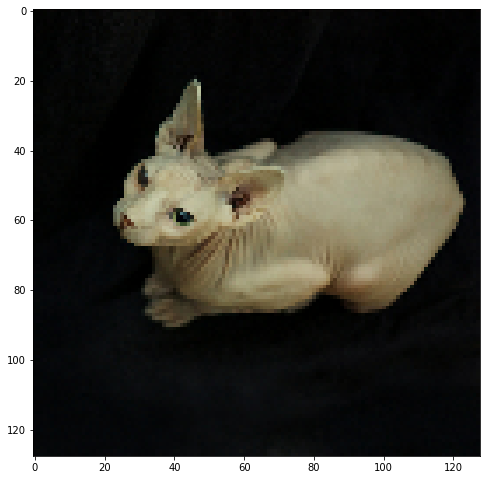

In [34]:
plt.figure(figsize=(8, 10))
# plt.subplot(121)  
plt.imshow(list(train_images)[0][0])
# plt.subplot(122)  
# plt.imshow(list(train_images)[0][1])

In [14]:
def Unet(num_classes = 3, input_shape= (128, 128, 3)):
  #model - выходная модель

    img_input = Input(input_shape) # вход модели

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out) # 100x300

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out) # 50x150

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out) #25x75

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    #x = MaxPooling2D()(block_4_out)

    # Block 5
    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)


    # Load pretrained weights.
    #for_pretrained_weight = MaxPooling2D()(x)
    #vgg16 = Model(img_input, for_pretrained_weight)
    #vgg16.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)

    # UP 1
    #x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = concatenate([x, block_4_out])
    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    #x = Conv2D(512, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) #50x150
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) # 100x300
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # 200x600
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), 
#                activation='softmax', 
               padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
                  # metrics=[dice_coef]
                 )
    model.summary()
    return model

In [15]:
modelC = Unet(3, (128, 128, 3))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
print("On GPU:")
with tf.device("GPU:0"):
    history = modelC.fit(train_batches, epochs=10, 
                         batch_size=10, 
                         validation_data=test_batches)

On GPU:
Epoch 1/10
74/74 [==============================] - 146s 2s/step - loss: 0.6777 - accuracy: 0.7054 - val_loss: 1.6390 - val_accuracy: 0.5205
Epoch 2/10
74/74 [==============================] - 122s 2s/step - loss: 0.5430 - accuracy: 0.7738 - val_loss: 0.8068 - val_accuracy: 0.7002
Epoch 3/10
74/74 [==============================] - 121s 2s/step - loss: 0.4687 - accuracy: 0.8066 - val_loss: 1.0380 - val_accuracy: 0.6934
Epoch 4/10
74/74 [==============================] - 121s 2s/step - loss: 0.4162 - accuracy: 0.8282 - val_loss: 1.4899 - val_accuracy: 0.6315
Epoch 5/10
74/74 [==============================] - 121s 2s/step - loss: 0.3794 - accuracy: 0.8429 - val_loss: 1.2489 - val_accuracy: 0.6577
Epoch 6/10
74/74 [==============================] - 121s 2s/step - loss: 0.3541 - accuracy: 0.8535 - val_loss: 0.4475 - val_accuracy: 0.8249
Epoch 7/10
74/74 [==============================] - 121s 2s/step - loss: 0.3346 - accuracy: 0.8611 - val_loss: 0.4437 - val_accuracy: 0.8342
Epoch

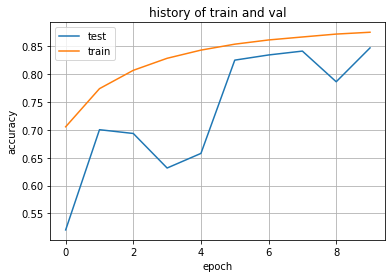

In [20]:
plt.plot(history.history['val_accuracy'],label = 'test')
plt.plot(history.history['accuracy'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.title('history of train and val')
plt.show()

In [22]:
pred = modelC.predict(test_batches)
print(pred.shape)

(3669, 128, 128, 3)


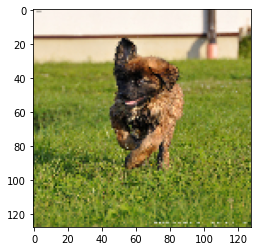

In [41]:
plt.imshow(list(test_images)[0][0])

Text(0.5, 1.0, 'предиктивная разметка класс: 2')

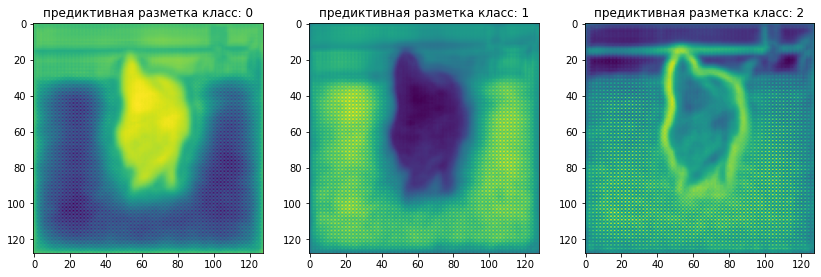

In [39]:
n = 0

plt.figure(figsize=(14, 20))
plt.subplot(131)
img = pred[n][:,:,0]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(0))

plt.subplot(132)
img = pred[n][:,:,1]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(1))

plt.subplot(133)
img = pred[n][:,:,2]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(2))

In [ ]:
# Претренированная модель

In [66]:
dataset_name = "oxford_iiit_pet"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

In [67]:
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

In [68]:
ds_train

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [69]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [71]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

In [73]:
print("On GPU:")
with tf.device("GPU:0"):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    model.summary()

epochs = 10
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

On GPU:
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 37)               4096968   
                                                                 
Total params: 4,096,968
Trainable params: 4,054,945
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/10
73/73 - 97s - loss: 4.2544 - accuracy: 0.0340 - val_loss: 3.6427 - val_accuracy: 0.0274 - 97s/epoch - 1s/step
Epoch 2/10
73/73 - 76s - loss: 3.8775 - accuracy: 0.0468 - val_loss: 3.8522 - val_accuracy: 0.0274 - 76s/epoch - 

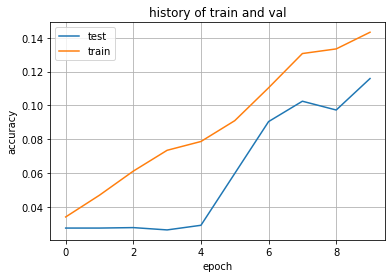

In [74]:
plt.plot(hist.history['val_accuracy'],label = 'test')
plt.plot(hist.history['accuracy'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.title('history of train and val')
plt.show()

In [75]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [76]:
print("On GPU:")
with tf.device("GPU:0"):
    model = build_model(num_classes=NUM_CLASSES)

epochs = 10
hist2 = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

On GPU:
16719872/16705208 [==============================] - 1s 0us/step
Epoch 1/10
73/73 - 46s - loss: 2.0432 - accuracy: 0.5841 - val_loss: 0.5023 - val_accuracy: 0.8389 - 46s/epoch - 628ms/step
Epoch 2/10
73/73 - 38s - loss: 1.2258 - accuracy: 0.7447 - val_loss: 0.5073 - val_accuracy: 0.8447 - 38s/epoch - 516ms/step
Epoch 3/10
73/73 - 37s - loss: 1.0310 - accuracy: 0.7789 - val_loss: 0.6346 - val_accuracy: 0.8274 - 37s/epoch - 505ms/step
Epoch 4/10
73/73 - 32s - loss: 0.8679 - accuracy: 0.8058 - val_loss: 0.6351 - val_accuracy: 0.8455 - 32s/epoch - 439ms/step
Epoch 5/10
73/73 - 37s - loss: 0.7253 - accuracy: 0.8263 - val_loss: 0.7854 - val_accuracy: 0.8293 - 37s/epoch - 506ms/step
Epoch 6/10
73/73 - 32s - loss: 0.7235 - accuracy: 0.8315 - val_loss: 0.7260 - val_accuracy: 0.8488 - 32s/epoch - 444ms/step
Epoch 7/10
73/73 - 32s - loss: 0.6942 - accuracy: 0.8378 - val_loss: 0.8286 - val_accuracy: 0.8373 - 32s/epoch - 439ms/step
Epoch 8/10
73/73 - 32s - loss: 0.6624 - accuracy: 0.8427 - 

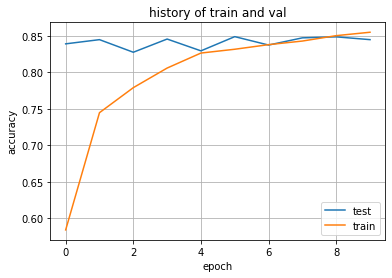

In [77]:
plt.plot(hist2.history['val_accuracy'],label = 'test')
plt.plot(hist2.history['accuracy'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.title('history of train and val')
plt.show()

Модель получилась достаточно "тяжелая", поэтому для повышения качества за счет усложнения потребуется больше вычислительных ресурсов. В данной ситуации улучшить метрику помогало увеличение количества эпох.